Воспроизведение численного моделирования уравнения ричардса из статьи
 из статьи

Solving for Light-loamy soil...
  Progress: 0.0% (0 min)
  Progress: 10.0% (200 min)
  Progress: 20.0% (400 min)
  Progress: 30.0% (600 min)
  Progress: 40.0% (800 min)
  Progress: 50.0% (1000 min)
  Progress: 60.0% (1200 min)
  Progress: 70.0% (1400 min)
  Progress: 80.0% (1600 min)
  Progress: 90.0% (1800 min)
  Completed Light-loamy soil simulation.
Solving for Medium-loamy soil...
  Progress: 0.0% (0 min)
  Progress: 10.0% (200 min)
  Progress: 20.0% (400 min)
  Progress: 30.0% (600 min)
  Progress: 40.0% (800 min)
  Progress: 50.0% (1000 min)
  Progress: 60.0% (1200 min)
  Progress: 70.0% (1400 min)
  Progress: 80.0% (1600 min)
  Progress: 90.0% (1800 min)
  Completed Medium-loamy soil simulation.
Solving for Heavy-loamy soil...
  Progress: 0.0% (0 min)
  Progress: 10.0% (200 min)
  Progress: 20.0% (400 min)
  Progress: 30.0% (600 min)
  Progress: 40.0% (800 min)
  Progress: 50.0% (1000 min)
  Progress: 60.0% (1200 min)
  Progress: 70.0% (1400 min)
  Progress: 80.0% (1600 min)
  P

<ipython-input-3-56895be2f1ea>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


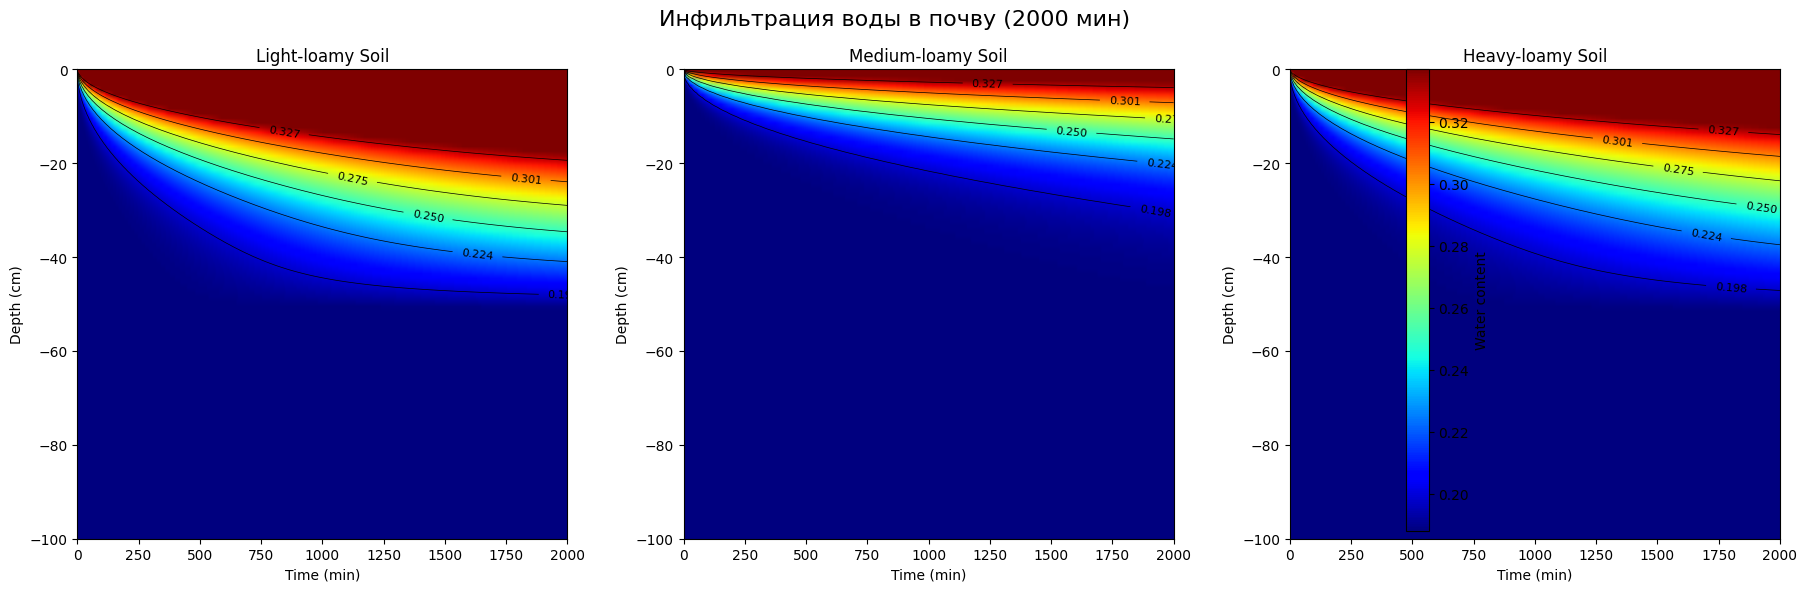

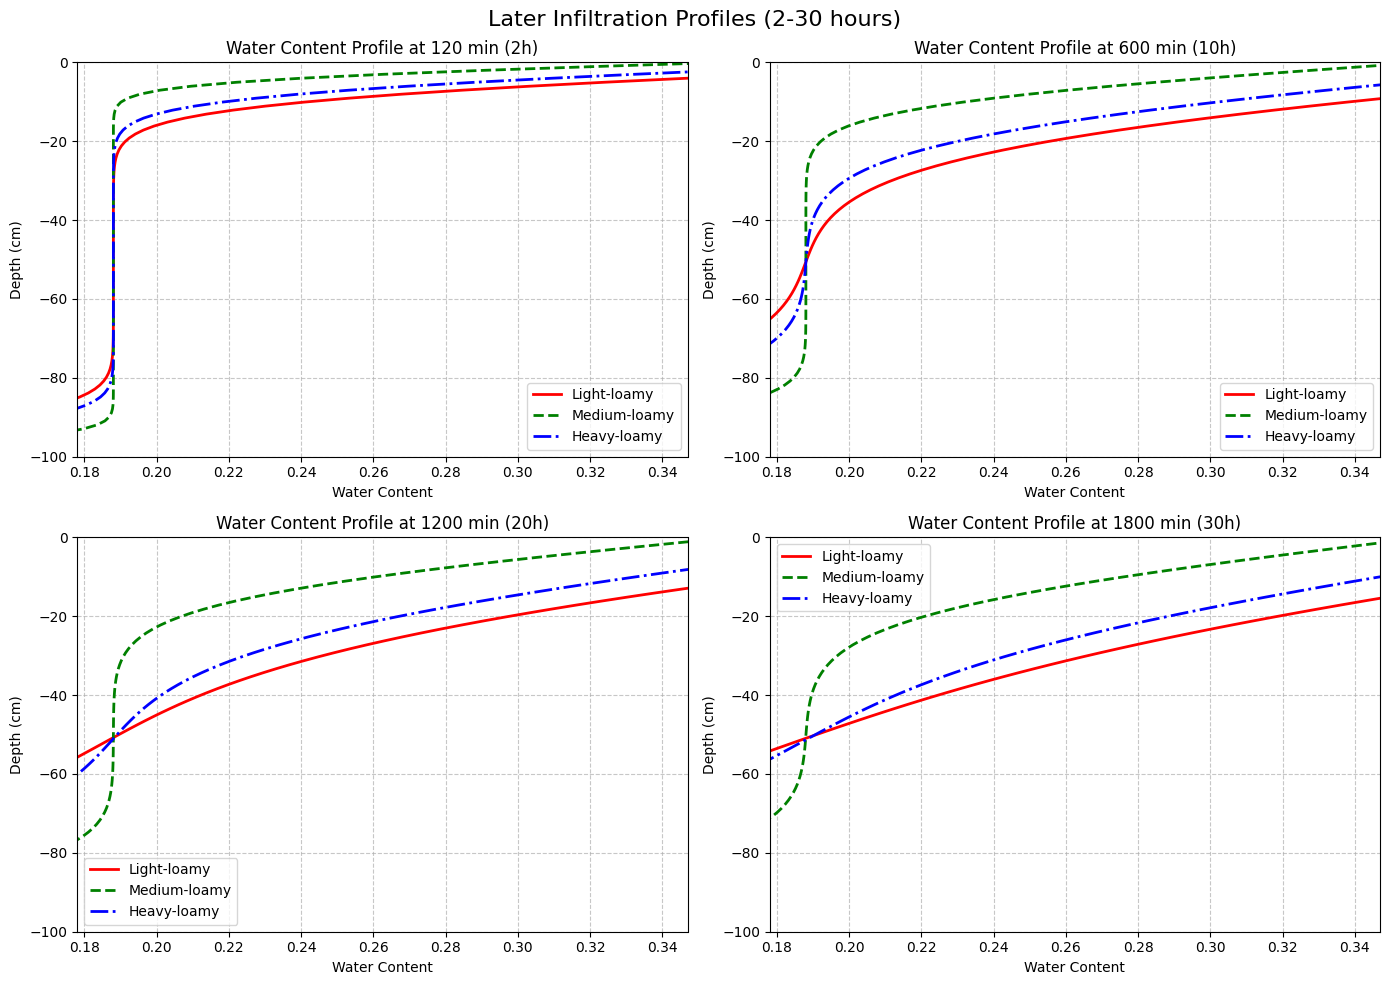

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import matplotlib.colors as colors

# Параметры почвы
soil_types = {
    "Light-loamy": {"N": 1.5844e-3, "D_bar": 2.6933e-1},
    "Medium-loamy": {"N": 1.1683e-5, "D_bar": 6.4401e-2},
    "Heavy-loamy": {"N": 1.2594e-4, "D_bar": 1.9088e-1},
}

# Определяем пространственную и временную сетку
z_max = 100  # Глубина в см
t_max = 2000  # Время в мин
dz = 1.0  # Шаг глубины в см
dt = 1.0  # Шаг времени в мин

Nz = int(z_max / dz)  # Количество узлов по глубине
Nt = int(t_max / dt) + 1  # Количество временных шагов

# Начальные и граничные условия
theta_0 = 0.188  # Начальное содержание влаги
theta_s = 0.337  # Влага на поверхности

# Создаем массивы времени и глубины
time_points = np.linspace(0, t_max, Nt)
depth_points = np.linspace(0, -z_max, Nz)

# Решение уравнения Ричардса
theta_results = {}
for soil, params in soil_types.items():
    print(f"Solving for {soil} soil...")
    N = params["N"]
    D_bar = params["D_bar"]

    # Массив влажности
    theta = np.full((Nz, Nt), theta_0)
    theta[0, :] = theta_s  # Граничное условие на поверхности

    # Численный расчет
    for n in range(0, Nt-1):
        if n % (Nt//10) == 0:
            print(f"  Progress: {n/Nt*100:.1f}% ({n*dt:.0f} min)")

        alpha = (D_bar * dt) / (dz ** 2)
        beta = (N * dt) / (2 * dz)

        main_diag = np.ones(Nz) * (1 + 2*alpha)
        upper_diag = np.ones(Nz-1) * (-alpha - beta)
        lower_diag = np.ones(Nz-1) * (-alpha + beta)

        main_diag[0] = 1.0
        lower_diag[-1] = -alpha

        A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1]).toarray()
        b = np.copy(theta[:, n])
        b[0] = theta_s

        theta[:, n+1] = np.linalg.solve(A, b)

    print(f"  Completed {soil} soil simulation.")
    theta_results[soil] = theta

print("All simulations completed!")

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = plt.cm.jet
norm = colors.Normalize(vmin=theta_0, vmax=theta_s)

for i, soil in enumerate(soil_types.keys()):
    theta = theta_results[soil]

    im = axes[i].imshow(
        theta,
        extent=[0, t_max, -z_max, 0],
        aspect='auto',
        origin='upper',
        cmap=cmap,
        norm=norm,
        interpolation='bilinear'
    )

    contour_levels = np.linspace(theta_0 + 0.01, theta_s - 0.01, 6)
    cs = axes[i].contour(
        time_points,
        depth_points,
        theta,
        levels=contour_levels,
        colors='k',
        linewidths=0.5,
        linestyles='solid'
    )
    axes[i].clabel(cs, inline=True, fontsize=8, fmt='%.3f')

    axes[i].set_xlabel("Time (min)")
    axes[i].set_ylabel("Depth (cm)")
    axes[i].set_title(f"{soil} Soil")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), location="right")
cbar.set_label('Water content')
plt.suptitle('Инфильтрация воды в почву (2000 мин)', fontsize=16)
plt.tight_layout()
plt.show()

# Визуализация профилей влажности
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
later_time_indices = [int(t/dt) for t in [120, 600, 1200, 1800]]
later_time_labels = ['120 min (2h)', '600 min (10h)', '1200 min (20h)', '1800 min (30h)']

for i, (time_idx, time_label) in enumerate(zip(later_time_indices, later_time_labels)):
    for soil, color, linestyle in zip(
        soil_types.keys(),
        ['red', 'green', 'blue'],
        ['-', '--', '-.']
    ):
        axes[i].plot(
            theta_results[soil][:, time_idx],
            depth_points,
            label=f"{soil}",
            color=color,
            linestyle=linestyle,
            linewidth=2
        )

    axes[i].set_ylim(-100, 0)
    axes[i].set_xlim(theta_0 - 0.01, theta_s + 0.01)
    axes[i].set_xlabel('Water Content')
    axes[i].set_ylabel('Depth (cm)')
    axes[i].set_title(f'Water Content Profile at {time_label}')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].legend()

plt.suptitle('Later Infiltration Profiles (2-30 hours)', fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-10-1ff3edc58502>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


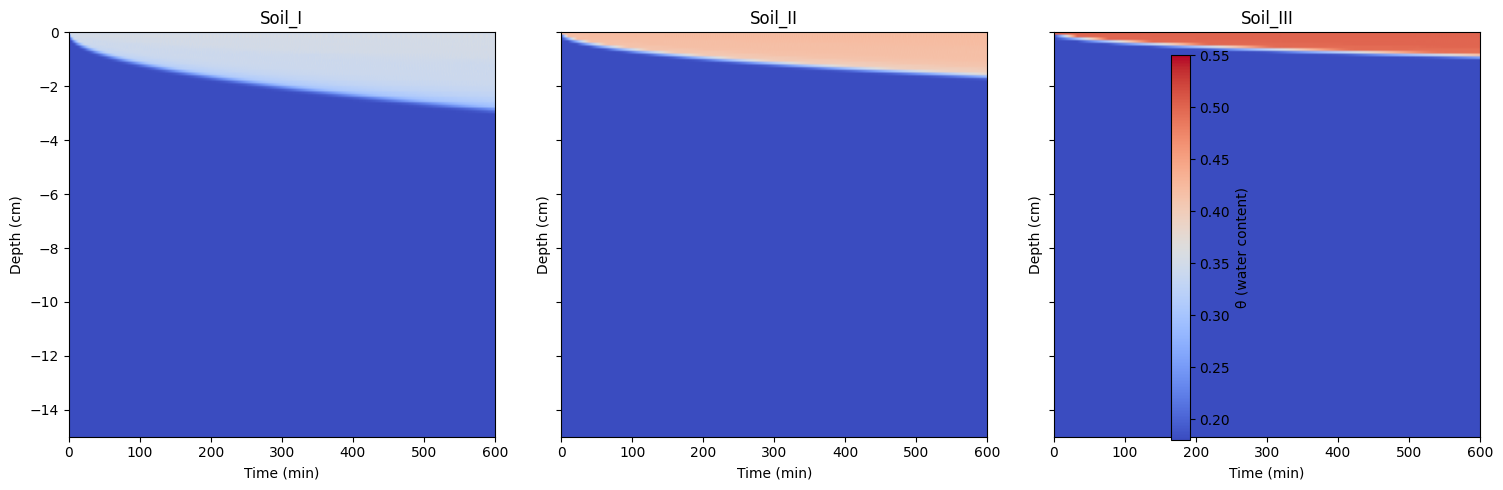

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import matplotlib.colors as colors

# Параметры почвы

soil_types = {
    "Soil_I": {
        "theta_s": 0.35, "theta_r": 0.07,
        "alpha": 0.08, "n": 1.55,
        "Ks": 0.003, "D0": 1e-5
    },
    "Soil_II": {
        "theta_s": 0.42, "theta_r": 0.09,
        "alpha": 0.04, "n": 1.45,
        "Ks": 0.0012, "D0": 5e-6
    },
    "Soil_III": {
        "theta_s": 0.50, "theta_r": 0.10,
        "alpha": 0.02, "n": 1.35,
        "Ks": 0.0004, "D0": 2e-6
    }
}

# Сетка
z_max = 15  # cm
t_max = 600  # min
dz = 0.1
dt = 0.5
Nz = int(z_max / dz)
Nt = int(t_max / dt) + 1

z = np.linspace(0, z_max, Nz)
t = np.linspace(0, t_max, Nt)

# Начальные условия
theta0 = 0.18

results = {}

def Se(theta, theta_r, theta_s):
    return np.clip((theta - theta_r) / (theta_s - theta_r), 0.001, 1.0)

def K_vgm(theta, Ks, theta_r, theta_s, n):
    m = 1 - 1/n
    Se_ = Se(theta, theta_r, theta_s)
    return Ks * (Se_ ** 0.5) * (1 - (1 - Se_ ** (1/m))**m)**2

def D_theta(theta, D0, Ks, theta_r, theta_s, n):
    return D0 * (K_vgm(theta, Ks, theta_r, theta_s, n) / Ks)

# Итерируемся по почвам
for name, params in soil_types.items():
    theta = np.ones((Nz, Nt)) * theta0
    theta[0, :] = params["theta_s"]

    for n in range(Nt-1):
        th = theta[:, n]
        new_th = th.copy()

        K = K_vgm(th, params["Ks"], params["theta_r"], params["theta_s"], params["n"])
        D = D_theta(th, params["D0"], params["Ks"], params["theta_r"], params["theta_s"], params["n"])

        alpha_arr = D * dt / dz**2
        beta_arr = np.gradient(K, dz) * dt / (2 * dz)

        main_diag = 1 + 2 * alpha_arr
        lower_diag = -alpha_arr[:-1] + beta_arr[:-1]
        upper_diag = -alpha_arr[1:] - beta_arr[1:]

        A = diags(
            diagonals=[lower_diag, main_diag, upper_diag],
            offsets=[-1, 0, 1],
            shape=(Nz, Nz)
        ).toarray()

        b = th.copy()
        b[0] = params["theta_s"]
        A[0, :] = 0
        A[0, 0] = 1
        A[-1, -1] = 1
        A[-1, -2] = -1
        b[-1] = 0

        theta[:, n+1] = np.linalg.solve(A, b)

    results[name] = theta

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
norm = colors.Normalize(vmin=0.18, vmax=0.55)
for ax, (name, theta) in zip(axes, results.items()):
    im = ax.imshow(
        theta,
        extent=[0, t_max, -z_max, 0],
        aspect='auto',
        cmap='coolwarm',
        norm=norm
    )
    ax.set_title(name)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Depth (cm)")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label="θ (water content)")
plt.tight_layout()
plt.show()


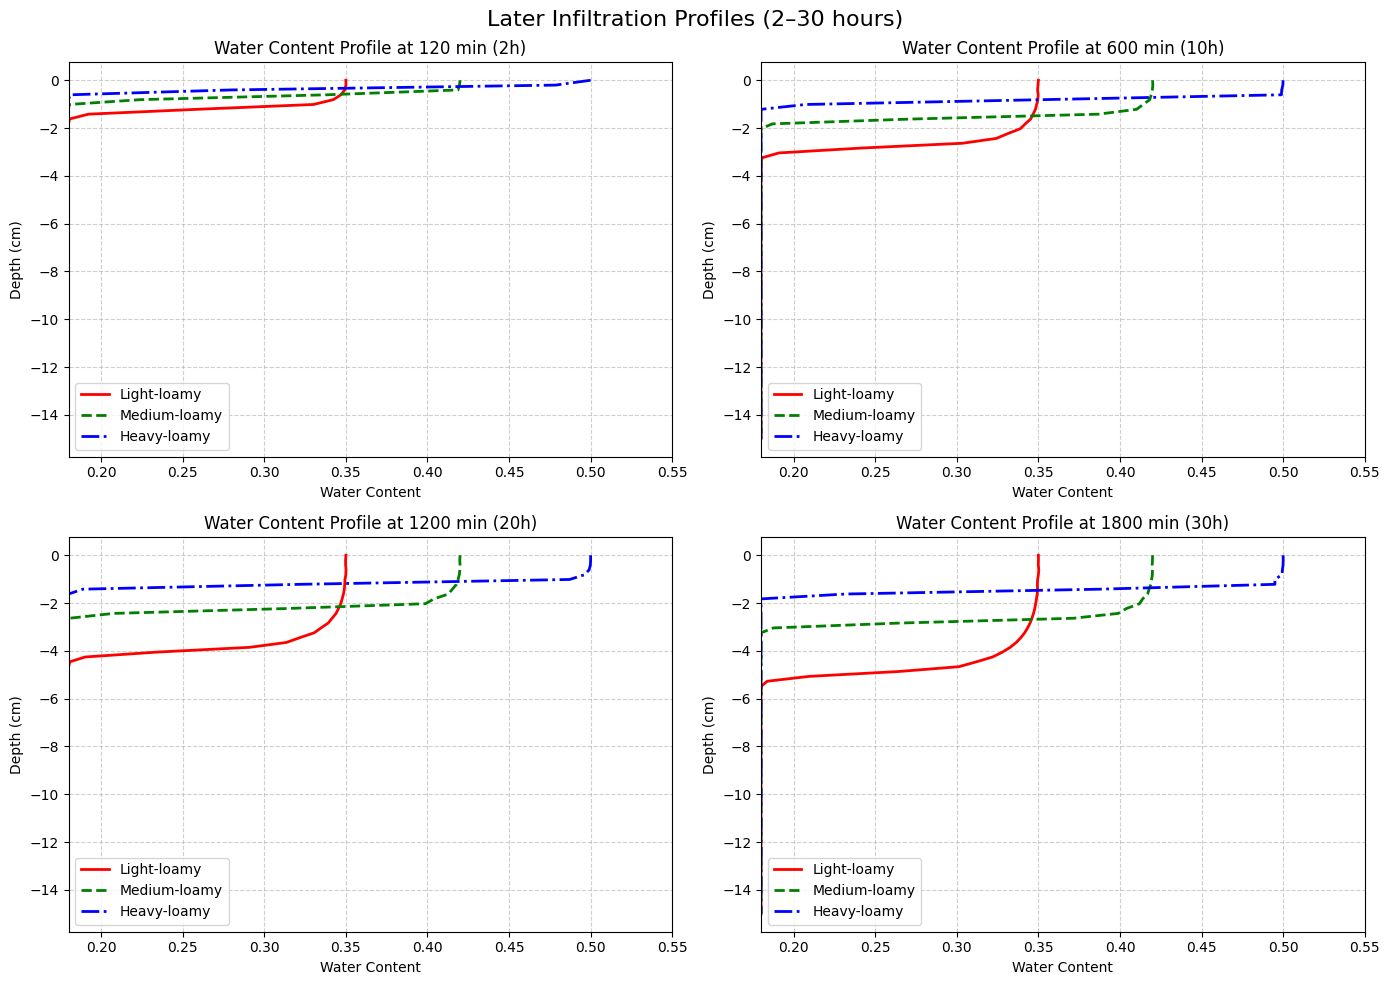

In [23]:
import numpy as np
import matplotlib.pyplot as plt

soil_types = {
    "Soil_I": {
        "theta_s": 0.35, "theta_r": 0.07,
        "alpha": 0.08, "n": 1.55,
        "Ks": 0.003, "D0": 1e-5
    },
    "Soil_II": {
        "theta_s": 0.42, "theta_r": 0.09,
        "alpha": 0.04, "n": 1.45,
        "Ks": 0.0012, "D0": 5e-6
    },
    "Soil_III": {
        "theta_s": 0.50, "theta_r": 0.10,
        "alpha": 0.02, "n": 1.35,
        "Ks": 0.0004, "D0": 2e-6
    }
}

# Сетка
z_max = 15
t_max = 2000  # (30+ часов)
dz = 0.2
dt = 0.25
Nz = int(z_max / dz)
Nt = int(t_max / dt) + 1

z = np.linspace(0, z_max, Nz)
t = np.linspace(0, t_max, Nt)

# Начальные условия
theta0 = 0.18
results = {}

# Функции модели
def Se(theta, theta_r, theta_s):
    return np.clip((theta - theta_r) / (theta_s - theta_r), 0.001, 1.0)

def K_vgm(theta, Ks, theta_r, theta_s, n):
    m = 1 - 1/n
    Se_ = Se(theta, theta_r, theta_s)
    return Ks * (Se_ ** 0.5) * (1 - (1 - Se_ ** (1/m))**m)**2

def D_theta(theta, D0, Ks, theta_r, theta_s, n):
    return D0 * (K_vgm(theta, Ks, theta_r, theta_s, n) / Ks)

from scipy.sparse import diags

# Расчёт
for name, params in soil_types.items():
    theta = np.ones((Nz, Nt)) * theta0
    theta[0, :] = params["theta_s"]

    for n in range(Nt-1):
        th = theta[:, n]

        K = K_vgm(th, params["Ks"], params["theta_r"], params["theta_s"], params["n"])
        D = D_theta(th, params["D0"], params["Ks"], params["theta_r"], params["theta_s"], params["n"])

        alpha_arr = D * dt / dz**2
        beta_arr = np.gradient(K, dz) * dt / (2 * dz)

        main_diag = 1 + 2 * alpha_arr
        lower_diag = -alpha_arr[:-1] + beta_arr[:-1]
        upper_diag = -alpha_arr[1:] - beta_arr[1:]

        A = diags(
            diagonals=[lower_diag, main_diag, upper_diag],
            offsets=[-1, 0, 1],
            shape=(Nz, Nz)
        ).toarray()

        b = th.copy()
        b[0] = params["theta_s"]
        A[0, :] = 0
        A[0, 0] = 1
        A[-1, -1] = 1
        A[-1, -2] = -1
        b[-1] = 0

        theta[:, n+1] = np.linalg.solve(A, b)

    results[name] = theta

# Построение графиков профилей влажности
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
times = [120, 600, 1200, 1800]  # мин
colors_dict = {"Soil_I": "red", "Soil_II": "green", "Soil_III": "blue"}
styles_dict = {"Soil_I": "-", "Soil_II": "--", "Soil_III": "-."}
labels_dict = {"Soil_I": "Light-loamy", "Soil_II": "Medium-loamy", "Soil_III": "Heavy-loamy"}

for i, t_val in enumerate(times):
    t_idx = int(t_val / dt)
    for soil_name in soil_types:
        axes[i].plot(results[soil_name][:, t_idx], -z,
                     label=labels_dict[soil_name],
                     color=colors_dict[soil_name],
                     linestyle=styles_dict[soil_name],
                     linewidth=2)

    axes[i].set_title(f"Water Content Profile at {t_val} min ({t_val//60}h)")
    axes[i].set_xlabel("Water Content")
    axes[i].set_ylabel("Depth (cm)")
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].set_xlim(0.18, 0.55)
    axes[i].legend()

plt.suptitle("Later Infiltration Profiles (2–30 hours)", fontsize=16)
plt.tight_layout()
plt.show()
